In [2]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
os.path.exists("/nrs/saalfeld/heinrichl")

True

In [4]:
zf = zarr.open("/nrs/saalfeld/heinrichl/mlflow_tracking/diffusion/552616204068621555/f2bfec30d0c4416099c4e22248c33e06/artifacts/samples.zarr", "r")

In [24]:
arr = np.array(zf["449"])
shape = list(arr.shape)
shape[0] = 1
#arr = np.concatenate([np.zeros_like(arr, shape=shape), arr], axis=0)

In [25]:
arr.shape

(31, 652, 652)

In [7]:
def colorize(img: np.array, colors = None, color_threshold=0):
    # img ch, x, y
    if img.ndim == 4:  # s, ch, x, y
        color_axis = 1
    elif img.ndim == 3:  # ch, x, y
        color_axis = 0
    else:
        msg = f"Can't handle arrays with {img.ndim} dimensions for colorizing"
        raise ValueError(msg)
    if colors is None or len(colors) < img.shape[color_axis]:
        new_colors = distinctipy.get_colors(img.shape[color_axis], colors=colors)
        if colors is None:
            colors = new_colors
        else:
            colors = colors.extend(new_colors)
    img[img <= color_threshold] = 0
    # find for each pixel which image has max value
    max_lbl_id_arr = np.argmax(img, axis=color_axis, keepdims=True)
    # keep track of what those actual values are
    max_lbl_val_arr = np.take_along_axis(img, max_lbl_id_arr, axis=color_axis)
    target_shape = list(img.shape)
    target_shape[color_axis] = 3
    rgb_image = np.zeros(target_shape)
    # normalizing_image = np.zeros((1, img.shape[1], img.shape[2]), dtype=np.uint8)
    for lbl_id, color in zip(range(img.shape[color_axis]), colors):
        lbl_bin_arr = max_lbl_id_arr == lbl_id
        lbl_arr = max_lbl_val_arr * lbl_bin_arr
        rgb_img_tpl = tuple(lbl_arr * col for col in color)
        rgb_image += np.concatenate(rgb_img_tpl, axis=color_axis)
    if np.issubdtype(img.dtype, np.integer):
        rgb_image = np.round(rgb_image).astype(img.dtype)

    return rgb_image

In [8]:
def rgb_labels(img: np.array, colors):
    if img.ndim == 4 and img.shape[1] == 1:  # s, ch, x, y
        color_axis = 1
    elif img.ndim == 3 and img.shape[0] == 1:  # ch, x, y
        color_axis = 0
    elif img.ndim == 3:
        img = np.expand_dims(img, 1)
        color_axis = 1
    else:
        msg = f"Can't handle arrays with {img.ndim} dimensions for making labels"
        raise ValueError(msg)
    target_shape = list(img.shape)
    target_shape[color_axis] = 3
    rgb_image = np.zeros(target_shape, dtype=np.float32)
    for lbl_id, color in enumerate(colors):
        rgb_lbl_arr = tuple(((img == lbl_id) * col).astype(np.float32) for col in color)
        rgb_image += np.concatenate(rgb_lbl_arr, axis=color_axis)
    if np.issubdtype(img.dtype, np.integer):
        rgb_image = np.round(rgb_image * 255).astype(np.uint8)

    return rgb_image

In [9]:
def make_labels(img: np.array, label_threshold=0, add_bg=True):
    if img.ndim == 4:  # s, ch, x, y
        label_axis = 1
    elif img.ndim == 3:  # ch, x, y
        label_axis = 0
    else:
        msg = f"Can't handle arrays with {img.ndim} dimensions for making labels"
        raise ValueError(msg)
    img[img <= label_threshold] = 0
    if add_bg:
        shape = list(img.shape)
        shape[label_axis] = 1
        img = np.concatenate([np.zeros_like(img, shape=shape), img], axis=label_axis)
    max_lbl_id_arr = np.argmax(img, axis=label_axis, keepdims=True)
    return max_lbl_id_arr

In [10]:
def convert_color_to_float(
    color
) :
    if len(color) != 3:
        msg = f"Color tuple {color} is not of length 3"
        raise ValueError(msg)
    if not all(isinstance(col, type(color[0])) for col in color):
        msg = f"Inconsistent types in color tuple: {tuple(type(col) for col in color)}"
        raise ValueError(msg)
    if isinstance(color[0], int):
        for col in color:
            if col < 0 or col > 255:
                msg = f"Integer color values should be in range [0, 255]; found {color}"
                raise ValueError(msg)
        return tuple(col / 255.0 for col in color)
    elif isinstance(color[0], float):
        for col in color:
            if col < 0 or col > 1:
                msg = f"Float color values should be in range [0, 1]; found {color}"
                raise ValueError(msg)
        return color
    else:
        msg = f"Can't handle color values of type {color[0]}"
        raise TypeError(msg)


In [11]:
my_colors =[
      [50, 50, 50],
      [100, 100, 100],
      [255, 128, 0],
      [128, 64, 0],
      [220, 172, 104],
      [0, 132, 255],
      [0, 66, 128],
      [255, 0, 0],
      [128, 0, 0],
      [0, 0, 255],
      [0, 0, 128],
      [255, 216, 0],
      [128, 108, 0],
      [134, 164, 247],
      [79, 66, 252],
      [57, 215, 46],
      [51, 128, 46],
      [85, 254, 219],
      [6, 185, 157],
      [9, 128, 0],
      [5, 77, 0],
      [175, 249, 111],
      [252, 144, 211],
      [168, 55, 188],
      [84, 23, 94],
      [204, 0, 102],
      [102, 0, 51],
      [255, 0, 255],
      [247, 82, 104],
      [255, 255, 255],
      [128, 128, 128],
    ]

In [12]:
myfloat_colors = [convert_color_to_float(col) for col in my_colors]

In [26]:
colored = colorize(arr, colors=myfloat_colors, color_threshold = 10)

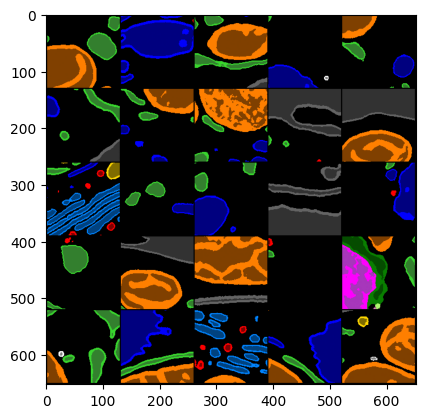

In [27]:
plt.imshow(colored.transpose((1,2,0)))

In [28]:
from PIL import Image

In [29]:
im = Image.fromarray(colored.transpose((1,2,0)))

In [30]:
im.save("/nrs/saalfeld/heinrichl/mlflow_tracking/diffusion/552616204068621555/f2bfec30d0c4416099c4e22248c33e06/artifacts/samples/449.png", format="PNG")

In [ ]:
labels = make_labels(arr, label_threshold=10)

In [ ]:
np.unique(labels)

In [ ]:
plt.imshow((labels == 8).squeeze())

In [ ]:
x  = rgb_labels(labels, colors= my_colors)

In [ ]:
x.shape

In [ ]:
x[2][arr[3]> 10]

In [ ]:
x.shape

In [ ]:
[arr[3]> 10]

In [ ]:
plt.imshow(arr[3]> 30)